<a href="https://colab.research.google.com/github/copyleftist/CovidGameSimulation/blob/main/CovidSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np

import itertools as it
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd

import tqdm

In [34]:
"""
Models
"""


class SimpleAgent:
    """
    stupid agent
    """
    def __init__(self, money, factor, possible_factors,
                     alpha, lr_contrib, beta):
        self.factor = factor
        self.money = money

        self.lr_contrib = lr_contrib
        self.alpha = alpha
        self.beta = beta

        self.q = {k: v for k in [True, False]
                  for v in [
                      {k2: 0 for k2 in [None, ] + possible_factors}
                  ]}

        self.y_contrib = {k: v for k in [True, False]
                          for v in [
                              {k2: np.ones(self.money)
                               for k2 in [None, ] + possible_factors}
                          ]}

    def contribute(self, opp_factor, disclosed):
        return np.random.choice(range(1, 11), p=[.0, .0, .0, .0, .0,
                                                 .0, .0, .0, .3, .7])

    def disclose(self):
        disclosed = np.random.random() < .8
        return disclosed, self.factor if disclosed else None

    def update_contrib_posterior(self, disclosed, opp_factor, opp_contrib):
        pass

    def learn(self, reward, disclosed, opp_type):
        pass

    def softmax(self, values):
        return np.exp(values*self.beta)/np.sum(np.exp(values*self.beta))


class BayesianAgent:
    """
    Optimal agent
    """
    def __init__(self, money, factor, possible_factors,
                 alpha, lr_contrib, beta):
        self.factor = factor
        self.money = money

        self.lr_contrib = lr_contrib

        self.alpha = alpha
        self.beta = beta

        self.q = {k: v for k in [True, False]
                  for v in [
                      {k2: 0 for k2 in [None, ] + possible_factors}
        ]}

        self.y_contrib = {k: v for k in [True, False]
                    for v in [
                        {k2: np.ones(self.money)
                         for k2 in [None, ] + possible_factors}
         ]}

    def contribute(self, opp_factor, disclosed):
        p_opp = stats.dirichlet(self.y_contrib[disclosed][opp_factor]).mean()
        expected_rewards = np.zeros((self.money, self.money))

        if opp_factor is None:
            opp_factor = 1

        for idx1, c1 in enumerate(range(1, self.money+1)):
            for idx2, c2 in enumerate(range(1, self.money + 1)):
                expected_rewards[idx1, idx2] = \
                    ((self.factor*c1 + opp_factor*c2)/2 - c1) * p_opp[idx2]

        max_er = np.max(expected_rewards, axis=1)

        # return max_er+1

        return np.random.choice(range(1, self.money+1), p=self.softmax(max_er))

    def disclose(self):
        q = np.array([
            np.sum(list(self.q[False].values())),
            np.sum(list(self.q[True].values()))
        ])

        disclosed = np.random.choice([False, True], p=self.softmax(q))
        return disclosed, self.factor if disclosed else None

    def update_contrib_posterior(self, disclosed, opp_factor, opp_contrib):
        self.y_contrib[disclosed][opp_factor][opp_contrib-1] += self.lr_contrib

    def learn(self, reward, disclosed, opp_type):
        self.q[disclosed][opp_type] += self.alpha * (reward - self.q[disclosed][opp_type])

    def softmax(self, values):
        return np.exp(values*self.beta)/np.sum(np.exp(values*self.beta))
    



In [35]:
"""
main functions to run the simulations
"""

def generate_agents(n_agents, ratio, types, money, agent_class):

    factors = [types[0], ] * int((n_agents*ratio[0]))\
            + [types[1], ] * int((n_agents*ratio[1]))
    np.random.shuffle(factors)

    alphas = np.random.beta(1, 1, size=n_agents).tolist()
    betas = np.random.gamma(1.2, 5, size=n_agents).tolist()
    lr_contrib = np.random.gamma(1.2, 5, size=n_agents).tolist()

    agents = []
    for _ in range(n_agents):
        agents.append(
                agent_class(money=money, factor=factors.pop(),
                    possible_factors=types, alpha=alphas.pop(),
                    lr_contrib=lr_contrib.pop(), beta=betas.pop()
        ))

    return agents


def main(money=10, n_agents=100, n_trials=200, types=[.8, 1.2], ratio=[.5, .5]):

    # generate all the agents
    agents = generate_agents(
        n_agents, ratio, types, money, BayesianAgent)

    dd = []

    for t in tqdm.tqdm(range(n_trials)):

        agent_ids = list(range(n_agents))
        np.random.shuffle(agent_ids)

        for round_id in range(n_agents//2):

            id1 = agent_ids.pop()
            id2 = agent_ids.pop()

            a1 = agents[id1]
            a2 = agents[id2]

            a1_disclosed, f1 = a1.disclose()
            a2_disclosed, f2 = a2.disclose()

            if t == 0:
                c1 = np.random.choice(range(1, money+1))
                c2 = np.random.choice(range(1, money+1))
            else:
                c1 = a1.contribute(opp_factor=f2, disclosed=a1_disclosed)
                c2 = a2.contribute(opp_factor=f1, disclosed=a2_disclosed)

            r1 = ((c1*a1.factor + c2*a2.factor)/2) - c1
            r2 = ((c1*a1.factor + c2*a2.factor)/2) - c2

            max1 = np.zeros(money)
            max2 = np.zeros(money)
            for idx, c in enumerate(range(1, 11)):
                max1[idx] = ((c*a1.factor + c2*a2.factor)/2) - c
                max2[idx] = ((c1*a1.factor + c*a2.factor)/2) - c

            corr1 = c1 in np.arange(1, money+1)[np.max(max1)==max1]
            corr2 = c2 in np.arange(1, money+1)[np.max(max2)==max2]

            a1.update_contrib_posterior(
                opp_contrib=c2, opp_factor=f2, disclosed=a1_disclosed)
            a2.update_contrib_posterior(
                opp_contrib=c1, opp_factor=f1, disclosed=a2_disclosed)

            a1.learn(r1, a1_disclosed, f2)
            a2.learn(r2, a2_disclosed, f1)

            dd.append(
                {'round_id': f'{t}_{round_id}', 'id': id1,
                 'c': c1, 't': t, 'f': 'bad' if a1.factor == types[0] else 'good',
                 'd': a1_disclosed, 'r': r1, 'class': a1.__class__.__name__, 'corr': corr1,
                }
            )

            dd.append(
                {'round_id': f'{t}_{round_id}', 'id': id2,
                 'c': c2, 't': t, 'f': 'bad' if a2.factor == types[0] else 'good',
                 'd': a2_disclosed, 'r': r2, 'class': a2.__class__.__name__, 'corr': corr2,
                } 
            )

    df = pd.DataFrame(data=dd)

    return df

In [40]:
money = 10
n_agents = 100
n_trials = 200
types = [.8, 1.2]
ratio = [.5, .5]

#RUN SIMULATIONS AND DISPLAY THE DATAFRAME
df = main()
df

100%|██████████| 200/200 [00:10<00:00, 19.50it/s]


,round_id,id,c,t,f,d,r,class,corr
0,0_0,65,1,0,bad,True,4.2,BayesianAgent,True
1,0_0,88,8,0,good,False,-2.8,BayesianAgent,False
2,0_1,61,8,0,bad,True,-3.2,BayesianAgent,False
3,0_1,31,4,0,bad,False,0.8,BayesianAgent,False
4,0_2,57,10,0,bad,False,-0.6,BayesianAgent,False
...,...,...,...,...,...,...,...,...,...
19995,199_47,8,6,199,bad,False,-2.8,BayesianAgent,False
19996,199_48,74,8,199,bad,False,-4.4,BayesianAgent,False
19997,199_48,77,1,199,bad,False,2.6,BayesianAgent,True
19998,199_49,76,5,199,bad,True,-2.2,BayesianAgent,False


# **PLOTS**


*   check agents correct response rate



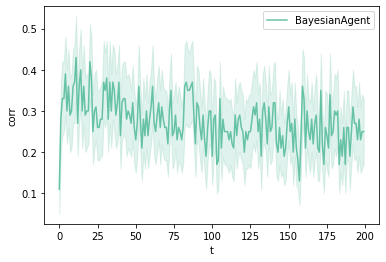

In [37]:

sns.set_palette('Set2')


sns.lineplot(x='t', y='corr', hue='class', data=df)
plt.legend()
plt.show()



* plot agents contribution and disclosure levels



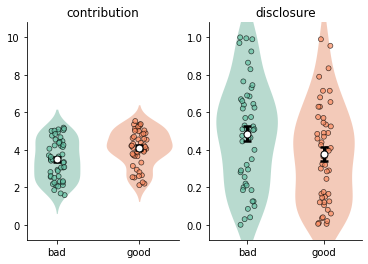

In [38]:

# Plot 1
ax = plt.subplot(121)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

df_mean = df.groupby(['id', 'f'], as_index=False)['c'].mean()
df_good = df_mean[df_mean['f'] == 'good']
df_bad = df_mean[df_mean['f'] == 'bad']

sem1 = stats.sem(df_bad['c'])
sem2 = stats.sem(df_good['c'])

mean1 = np.mean(df_bad['c'])
mean2 = np.mean(df_good['c'])

label = ['bad', 'good']
y = []
for i in range(2):
    y.append(df_mean[df_mean['f']==label[i]]['c'].tolist())

# sns.barplot(x=['bad', 'good'], y=[mean1, mean2], ci=None)
ax = sns.violinplot(data=y, inner=None, alpha=.2, linewidth=0)

for x in ax.collections:
    x.set_alpha(.5)

sns.stripplot(data=y, linewidth=.7, edgecolor='black', alpha=.7, zorder=9)
plt.errorbar(
    [0, 1], y=[mean1, mean2], yerr=[sem1, sem2], lw=3,
    markersize=7, marker='o', markerfacecolor='w', markeredgecolor='black',
    capsize=4, capthick=2.5, ecolor='black', ls='none', zorder=10)

plt.title('contribution')
# ax.get_legend().remove()
plt.ylim([-0.08*10, 1.08*10])
plt.xticks(ticks=[0, 1], labels=['bad', 'good'])

 # Plot 2
ax = plt.subplot(122)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

df_mean = df.groupby(['id', 'f'], as_index=False)['d'].mean()
df_good = df_mean[df_mean['f'] == 'good']
df_bad = df_mean[df_mean['f'] == 'bad']

sem1 = stats.sem(df_bad['d'])
sem2 = stats.sem(df_good['d'])

mean1 = np.mean(df_bad['d'])
mean2 = np.mean(df_good['d'])

label = ['bad', 'good']
y = []
for i in range(2):
    y.append(df_mean[df_mean['f']==label[i]]['d'].tolist())

ax = sns.violinplot(data=y, inner=None, alpha=.2, linewidth=0)

for x in ax.collections:
    x.set_alpha(.5)

sns.stripplot(data=y, linewidth=.7, edgecolor='black', zorder=9, alpha=.7)
plt.errorbar(
    [0, 1], y=[mean1, mean2], yerr=[sem1, sem2], lw=3, markersize=7, marker='o',
    markerfacecolor='w', markeredgecolor='black',
    capsize=4, capthick=2.5, ecolor='black', ls='none', zorder=10)

plt.title('disclosure')
plt.ylim([-0.08, 1.08])
plt.xticks(ticks=[0, 1], labels=['bad', 'good'])
# ax.get_legend().remove()
plt.show()


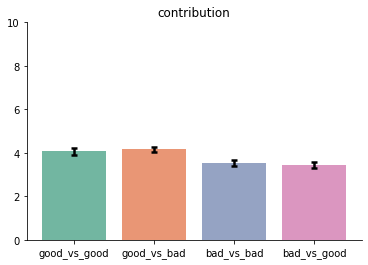

In [39]:
# plot 3
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# df_mean = df.groupby(['id', 'f', 'round_id'])['c'].mean()
dff = df[df.groupby(['round_id'])['f'].transform('nunique') > 1]
dff_gb = dff[dff['f']=='good']
dff_bg = dff[dff['f']=='bad']
dff = df[df.groupby(['round_id'])['f'].transform('nunique') == 1]
dff_gg = dff[dff['f']=='good']
dff_bb = dff[dff['f']=='bad']

hue_order = ['good_vs_good', 'good_vs_bad', 'bad_vs_bad', 'bad_vs_good']

sem1 = stats.sem(dff_gg.groupby('id')['c'].mean())
sem2 = stats.sem(dff_gb.groupby('id')['c'].mean())
sem3 = stats.sem(dff_bb.groupby('id')['c'].mean())
sem4 = stats.sem(dff_bg.groupby('id')['c'].mean())

mean1 = np.mean(dff_gg.groupby('id')['c'].mean())
mean2 = np.mean(dff_gb.groupby('id')['c'].mean())
mean3 = np.mean(dff_bb.groupby('id')['c'].mean())
mean4 = np.mean(dff_bg.groupby('id')['c'].mean())

sns.barplot(x=hue_order, y=[mean1, mean2, mean3, mean4], ci=None)
# import pdb;pdb.set_trace()
# sns.stripplot(x='f', y='c', data=dff.mean(),
#               linewidth=.6, alpha=.7, edgecolor='w')
plt.errorbar(
    [0, 1, 2, 3], y=[mean1, mean2, mean3, mean4], yerr=[sem1, sem2, sem3, sem4], lw=2.5,
    capsize=3, capthick=2.5, ecolor='black', ls='none', zorder=10)

plt.title('contribution')
plt.ylim([0,10])
plt.show()

